# Main-Model-2

PyTorch Faster R-CNN model trained and tested on a small sample of 135 images - more epochs

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install cython
$ pip install pycocotools
$ pip install torch-summary
```

### Helper functions

We will import some helper functions to simplify training and evaluating detection model. We will use `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [25]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [26]:
import scipy.io
import torch
import torch.utils.data
import torchvision

In [27]:
# ../src/pytorch-helpers/
module_path = os.path.abspath(os.path.join('../src/pytorch-helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [28]:
base_model_path = '../src/main-model/'

module_path = os.path.abspath(os.path.join(base_model_path))
if module_path not in sys.path:
    sys.path.append(module_path)

import fasterutils
import fasterrcnn

## Data

In [29]:
imgs_path = '../data/sample-dataset/'

In [10]:
imgs_person = os.listdir(imgs_path)
imgs = imgs_person

In [11]:
# anno_dict = np.load('../data/anno-big.npy', allow_pickle='TRUE').item()
anno_dict = np.load('anno-all.npy', allow_pickle='TRUE').item()

In [12]:
# imgs = list(anno_dict.keys())
len(imgs)

135

In [30]:
img_name = 'aachen_000031_000019_leftImg8bit.png'
img = Image.open(imgs_path + img_name)
bboxes = anno_dict[img_name]

In [31]:
plt.rcParams['figure.figsize'] = [12, 8]

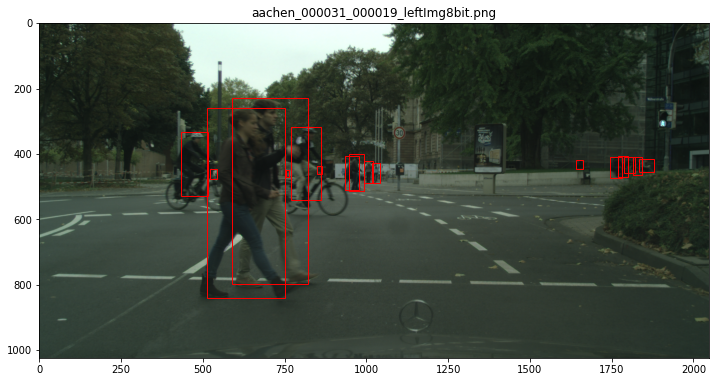

In [32]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [33]:
img_np = np.array(img)
H, W = img_np.shape[:2]
H, W

(1024, 2048)

## Prepare Torch.utils.data.Dataset class for this dataset

In [34]:
img_paths = [(imgs_path + img_name) for img_name in imgs]
# imgs1 = [img_path.split('/')[-1] for img_path in img_paths]
# imgs2 = list(anno_dict.keys())
# assert imgs1 == imgs2, 'Problems'
# assert imgs == imgs1, 'Problems'

In [35]:
dataset = fasterrcnn.Dataset(img_paths, imgs, anno_dict)

In [36]:
## test it
data = []
for i in range(len(dataset)):
    data.append(dataset[i])

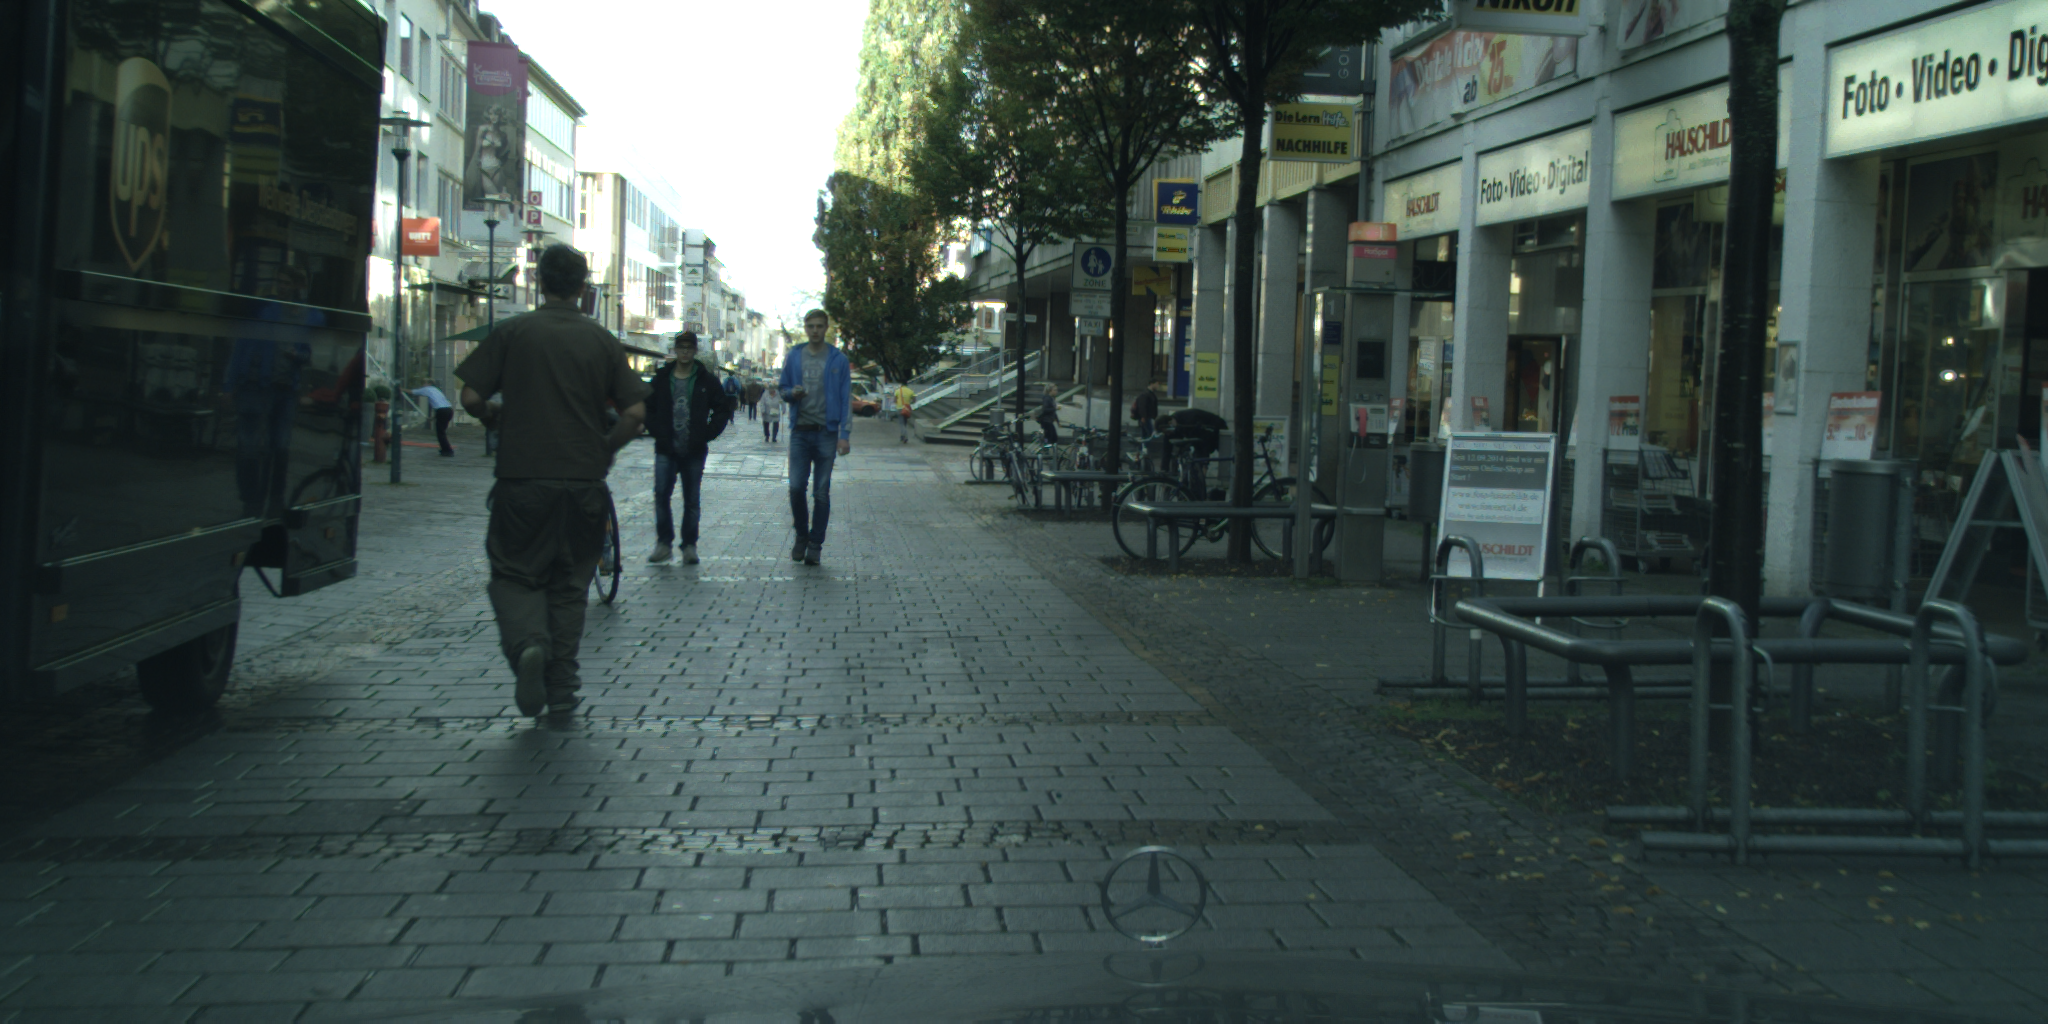

In [37]:
data[0][0]

## Train the model

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [38]:
## split the dataset into train and test
dataset = fasterrcnn.Dataset(
    img_paths,
    imgs,
    anno_dict, 
    fasterutils.get_transform(train=True))

dataset_test = fasterrcnn.Dataset(
    img_paths, 
    imgs,
    anno_dict, 
    fasterutils.get_transform(train=False))

## permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

In [39]:
## check it
print(len(indices), len(dataset_test))
print(dataset[0],  dataset_test[0])

135 135
(tensor([[[0.0431, 0.0392, 0.0392,  ..., 0.5882, 0.6000, 0.6078],
         [0.0510, 0.0431, 0.0431,  ..., 0.6196, 0.6196, 0.6196],
         [0.0549, 0.0471, 0.0471,  ..., 0.6471, 0.6510, 0.6510],
         ...,
         [0.1255, 0.1216, 0.1333,  ..., 0.1294, 0.1176, 0.1176],
         [0.1255, 0.1216, 0.1333,  ..., 0.1412, 0.1333, 0.1294],
         [0.1255, 0.1216, 0.1333,  ..., 0.1255, 0.1255, 0.1294]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.7373, 0.7255, 0.7255],
         [0.0706, 0.0706, 0.0784,  ..., 0.7647, 0.7529, 0.7529],
         [0.0784, 0.0784, 0.0824,  ..., 0.7882, 0.7843, 0.7843],
         ...,
         [0.1843, 0.1804, 0.1922,  ..., 0.1961, 0.1882, 0.1882],
         [0.1843, 0.1804, 0.1922,  ..., 0.2078, 0.2000, 0.1922],
         [0.1843, 0.1804, 0.1922,  ..., 0.1961, 0.1922, 0.1922]],

        [[0.0706, 0.0745, 0.0706,  ..., 0.6157, 0.6000, 0.6039],
         [0.0745, 0.0745, 0.0784,  ..., 0.6510, 0.6353, 0.6353],
         [0.0745, 0.0784, 0.0824,  ..., 0.6824, 0

In [40]:
## define train and test sets
dataset = torch.utils.data.Subset(dataset, indices[:-36])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-36:])

## define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [41]:
## check the results
print('Batch size = %d' % (data_loader.batch_size))

data_loader.dataset[0], data_loader.dataset[0]

Batch size = 2


((tensor([[[0.2706, 0.2706, 0.2706,  ..., 0.4000, 0.4000, 0.4078],
           [0.2706, 0.2706, 0.2706,  ..., 0.4039, 0.4039, 0.4039],
           [0.2745, 0.2706, 0.2745,  ..., 0.4039, 0.4000, 0.3922],
           ...,
           [0.2902, 0.2902, 0.2980,  ..., 0.2627, 0.2510, 0.2471],
           [0.2902, 0.2902, 0.2980,  ..., 0.2588, 0.2549, 0.2549],
           [0.2902, 0.2902, 0.2980,  ..., 0.2471, 0.2431, 0.2431]],
  
          [[0.3490, 0.3490, 0.3490,  ..., 0.5020, 0.5059, 0.5137],
           [0.3451, 0.3451, 0.3490,  ..., 0.5059, 0.5137, 0.5098],
           [0.3490, 0.3451, 0.3490,  ..., 0.5059, 0.5098, 0.5020],
           ...,
           [0.3412, 0.3373, 0.3373,  ..., 0.3137, 0.3020, 0.3020],
           [0.3412, 0.3373, 0.3373,  ..., 0.3098, 0.3059, 0.3098],
           [0.3412, 0.3373, 0.3373,  ..., 0.2980, 0.2941, 0.2980]],
  
          [[0.3176, 0.3137, 0.3137,  ..., 0.5176, 0.5216, 0.5176],
           [0.3176, 0.3137, 0.3137,  ..., 0.5216, 0.5255, 0.5176],
           [0.3176, 0.

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [43]:
model = fasterutils.get_model()
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [44]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [45]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 10 epochs, evaluating at the end of every epoch.

In [94]:
num_epochs = 10

tstart = time.time()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
tend = time.time()    

Epoch: [0]  [ 0/50]  eta: 0:01:09  lr: 0.000107  loss: 1.9154 (1.9154)  loss_classifier: 0.2541 (0.2541)  loss_box_reg: 0.4094 (0.4094)  loss_objectness: 0.7947 (0.7947)  loss_rpn_box_reg: 0.4573 (0.4573)  time: 1.3992  data: 0.6425  max mem: 1315
Epoch: [0]  [10/50]  eta: 0:00:33  lr: 0.001126  loss: 0.6757 (0.7560)  loss_classifier: 0.1709 (0.1698)  loss_box_reg: 0.3233 (0.3331)  loss_objectness: 0.0715 (0.1398)  loss_rpn_box_reg: 0.1113 (0.1133)  time: 0.8285  data: 0.0716  max mem: 1315
Epoch: [0]  [20/50]  eta: 0:00:24  lr: 0.002146  loss: 0.6903 (0.9183)  loss_classifier: 0.1709 (0.1857)  loss_box_reg: 0.3786 (0.3760)  loss_objectness: 0.0764 (0.1762)  loss_rpn_box_reg: 0.1161 (0.1803)  time: 0.7730  data: 0.0147  max mem: 1315
Epoch: [0]  [30/50]  eta: 0:00:15  lr: 0.003165  loss: 0.8231 (0.8644)  loss_classifier: 0.1749 (0.1852)  loss_box_reg: 0.3786 (0.3792)  loss_objectness: 0.0779 (0.1446)  loss_rpn_box_reg: 0.1230 (0.1553)  time: 0.7750  data: 0.0148  max mem: 1315
Epoch: [

***Training time on Nvidia Tesla K-80 GPU with 12GB memory:***

In [102]:
print('Time elapsed = %.2f min' % ((tend - tstart)/60))

Time elapsed = 11.80 min


## Error Analysis

### Ground truth

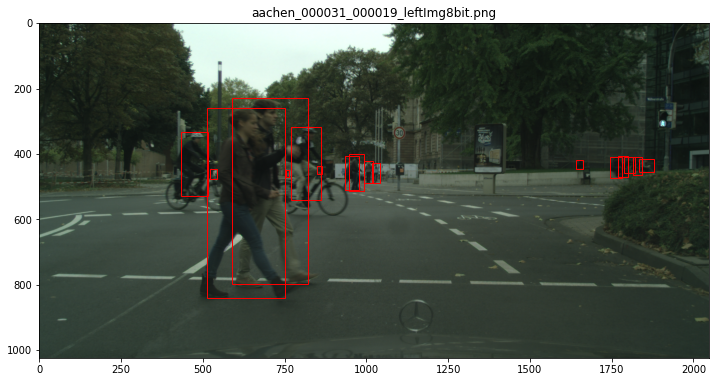

In [103]:
img_name = img_name = 'aachen_000031_000019_leftImg8bit.png'
img_path = imgs_path + img_name
img = Image.open(img_path)
np_image = np.array(img)

img_raw = img
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()

plt.title('Pedestrians detected')
ax.imshow(img)

bboxes = anno_dict[img_name]

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [104]:
dts = dataset[0]
dts_boxes = np.array(dts[1]['boxes'])

In [105]:
dts_boxes

array([[1745.,  426., 1760.,  464.],
       [1577.,  426., 1592.,  463.],
       [1426.,  408., 1465.,  501.],
       [1797.,  257., 1997.,  745.],
       [ 515.,  418.,  526.,  446.],
       [ 482.,  418.,  492.,  443.],
       [ 350.,  411.,  366.,  448.],
       [ 271.,  402.,  289.,  445.],
       [  59.,  399.,   81.,  453.],
       [ 138.,  412.,  154.,  451.],
       [  82.,  399.,  118.,  488.],
       [ 189.,  397.,  226.,  487.],
       [ 211.,  434.,  233.,  488.],
       [ 655.,  399.,  694.,  492.],
       [1046.,  404., 1086.,  500.],
       [ 996.,  409., 1034.,  501.],
       [ 969.,  399., 1012.,  503.],
       [ 922.,  405.,  959.,  496.],
       [ 933.,  416.,  969.,  503.],
       [ 682.,  299.,  869.,  753.],
       [ 528.,  415.,  542.,  448.]], dtype=float32)

In [106]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

### Predicted

In [107]:
def show(i, imgs, threshold=.3):
    img_name = imgs[i]
    img_path = imgs_path + img_name
    img = Image.open(img_path)
    ## np_image = np.array(img)
    img_raw = img

    #     idx = indices.index(i)
    img, anno = dataset_test[21]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    preds = prediction['boxes'] # predicted bboxes
    preds = preds.cpu().data.numpy() # to numpy array
    
    scores = prediction['scores'] # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
    
    ## keep only bboxes where score > threshold:
    highs = list(np.where(scores > threshold)[0])
    
    img = convert_back(img, img_raw)

    bboxes_x0x1y0y1 = []
    for high in highs:
        bboxes_x0x1y0y1.append(list(preds[high]))
        
    ## transform the bboxes from tensor to list and back to [x, y, w, h] format
    ## transform back to [x, y, w, h] format
    bboxes = []
    for bbox in bboxes_x0x1y0y1:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]

        bboxes.append([x0, y0, x1 - x0, y1 - y0])
    
    ## draw the predicted bounding boxes    
    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title('Pedestrians detected')
    plt.show()

After 1 epoch:

img shape: 1024 x 2048 x 3
Image was flipped: False


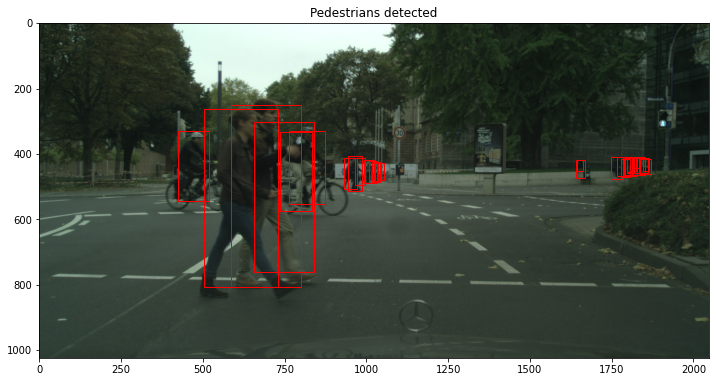

In [101]:
i = 22 # 21
show(i, imgs, threshold=.3)

After 10 epochs:

img shape: 1024 x 2048 x 3
Image was flipped: False


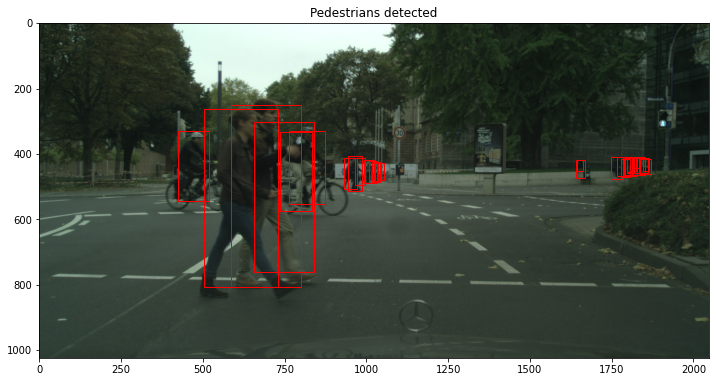

In [110]:
i = 22 # 21
show(i, imgs, threshold=.3)

Results

```
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
```